In [1]:
# This notebook calculates the returns over 1 through 15 bars for trading signals.
# Every signal is evaluated so this return does not reflect the returns that would have been realized
# by entering trades. Data is pulled from Yahoo finance for any given symbol.  Other data sources may
# be substituted in this cell.  The key fields are "Open", "High", "Low", and "Close".

# Import Yahoo finance and talib (for ATR calculations)
import yfinance as yf
import talib
import numpy as np
import random
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

# Get the desired ticker symbol
sym = " "
sym = input("Enter Symbol: ")

# Get test interval
print("valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo")
print("Intraday if period < 60 days)")
test_interval = ""
test_interval = input("Test Interval")

raise_error = 0
if test_interval == "1d" or test_interval == "5d" or test_interval == "1wk" or test_interval == "1mo" or test_interval == "3mo":
    # Set the desired Start and End Dates
    start_date = "2000-06-01"
    end_date = "2021-06-15"
elif test_interval == "1m" or test_interval == "2m" or test_interval == "5m" or test_interval == "15m" or test_interval == "30m" or test_interval == "60m" or test_interval == "90m":
    # Set the desired Start and End Dates
    start_date = "2021-05-01"
    end_date = "2021-06-15"
else:
    raise_error = 1
    print("Invalid test interval")
    
if raise_error == 0:
    # Get data from Yahoo Finance
    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d') 
    # For more data an alternative to Yahoo may be required
    ticker = yf.Ticker(sym)
    df = ticker.history(start=start_date, end=end_date, interval=test_interval)
    df = df.dropna()

    print(df.head(5))   

Enter Symbol: SPY
valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
Intraday if period < 60 days)
Test Interval15m
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-05-03 09:30:00-04:00  419.429993  419.440002  418.619995  419.140015   
2021-05-03 09:45:00-04:00  419.140015  419.839996  418.839996  419.488190   
2021-05-03 10:00:00-04:00  419.489990  419.660004  418.869995  419.364990   
2021-05-03 10:15:00-04:00  419.364990  419.739990  419.149994  419.350006   
2021-05-03 10:30:00-04:00  419.350006  419.739990  419.170013  419.184998   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2021-05-03 09:30:00-04:00  4089327          0             0  
2021-05-03 09:45:00-04:00  3162258          0             0  
2021-05-03 10:00:00-04:00  2820669          0             0  
2021-05-03 10:15:00-04

In [2]:
# TRADING SIGNAL GENERATION ALGORITHM
# The result of this cell is a trading signal AND a support level.  The output of this cell 
# must be a df['SIGNAL'] AND a df['SUPPORT'] column added to the dataframe.
# Any signal generation can be substituted as long as the result is a df['SIGNAL'] and
# df['SUPPORT'] value.

# ATRC Calculation

# This signal is based on Adam Grimes work on marketlifetrading.com.  Trade entry conditions:
# 1.  The ratio of the 5 bar ATR to the 40 bar ATR is less than an ATR threshold.
# 2.  The current bar's range is greater than the 5 bar ATR
# 3.  The current bar's close is in the top 50% of the range.

# Only a small number of trading signals are expected.

# Set the ATR threshold.  Settings between 0.5 and 0.9 are recommended.
# The higher the setting the more trades.
atr_threshold = 0.7

# Calculate ATRC indicator values and find signals.         
df['ATR5'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=5)
df['ATR40'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=40)

df.loc[(df['ATR40'] != 0), 'ATR Ratio'] = df['ATR5']/df['ATR40']

# Qualify signal - Set the signal value to zero to avoid nan
df['SIGNAL'] = 0
df.loc[(df['ATR Ratio'] < atr_threshold) & (df['ATR Ratio'] != 0) &
       (df['High'] - df['Low'] >= df['ATR5']) &
       (df['Close'] > df['Low'] + (df['High'] - df['Low']) * 0.6), 'SIGNAL'] = 1 

# Set the support leve to the low of the signal bar - Other values can be tested.
df.loc[(df['SIGNAL'] == 1), 'SUPPORT'] = df['Low']

print(df.head(5))

                                 Open        High         Low       Close  \
Datetime                                                                    
2021-05-03 09:30:00-04:00  419.429993  419.440002  418.619995  419.140015   
2021-05-03 09:45:00-04:00  419.140015  419.839996  418.839996  419.488190   
2021-05-03 10:00:00-04:00  419.489990  419.660004  418.869995  419.364990   
2021-05-03 10:15:00-04:00  419.364990  419.739990  419.149994  419.350006   
2021-05-03 10:30:00-04:00  419.350006  419.739990  419.170013  419.184998   

                            Volume  Dividends  Stock Splits  ATR5  ATR40  \
Datetime                                                                   
2021-05-03 09:30:00-04:00  4089327          0             0   NaN    NaN   
2021-05-03 09:45:00-04:00  3162258          0             0   NaN    NaN   
2021-05-03 10:00:00-04:00  2820669          0             0   NaN    NaN   
2021-05-03 10:15:00-04:00  2012614          0             0   NaN    NaN   
2021

In [3]:
# Determine the frequency of the trading signal

# How many bars are in the file?
bars = len(df)

# How many signals were generated?
signals = df['SIGNAL'].sum()

# Signal Frequency
cl_freq = 0
if bars != 0:
    cl_freq = signals/bars

print("There were ", signals, " signals")
print("Probablity of Trading Signal:  ", '{:2.2%}'.format(cl_freq))

There were  14  signals
Probablity of Trading Signal:   1.79%


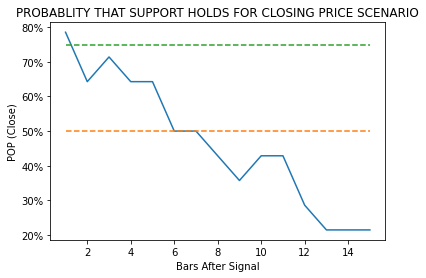

In [4]:
# CLOSING PRICE CALCULATIONS - Calculate the probability of support holding 
# based upon entering at the closing price.  Assumes you are watching the market and can enter 
# an options trade at the close of a bar.

# Clear the support column
for i in range(0,15):
    df['SCL' + str(i + 1)] = 0
    
# Test the closing price of each bar after the trading signal
for i in range(0,15):
    df.loc[(df['SIGNAL'] == 1) & 
           (df['Close'].shift(-(i+1)) > df['SUPPORT']), 'SCL' + str(i + 1)] = 1

# Find the probablity of support breaking.  These are not cummulative probabilities.
# Note that support could be broken on bar 2 and 7 in which case the violation of support
# would be recorded for both bars 2 and 7.  The assumption is that if you are interested
# in support at bar 7 you won't necessarily care about bar 2 breaking support.
pop_close = [0]*15
for i in range(0,15):
    if signals != 0:
        pop_close[i] = df['SCL' + str(i + 1)].sum()/signals

# Set up the plot x axis and reference lines for future plots        
bar_count = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
zeros = np.zeros_like(pop_close)
fifty = [.5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5]
seventy_five = [.75, .75, .75, .75, .75, .75, .75, .75, .75, .75, .75, .75, .75, .75, .75]

# Plot the support results
plt.title("PROBABLITY THAT SUPPORT HOLDS FOR CLOSING PRICE SCENARIO")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, pop_close)
plt.plot(bar_count, fifty, '--')
plt.plot(bar_count, seventy_five, '--')
plt.xlabel('Bars After Signal')
plt.ylabel('POP (Close)')
print("")


Frequency of Signal under evaluation (Close):   1.79%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   2.69%
Frequency of Random Signal:   0.64%
Frequency of Random Signal:   1.54%
Frequency of Random Signal:   2.56%
Frequency of Random Signal:   2.44%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   1.15%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   2.44%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   1.67%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.67%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   1.15%
Frequency of Random Signal:   1.79%
Frequency of Random Signal:   1.28%



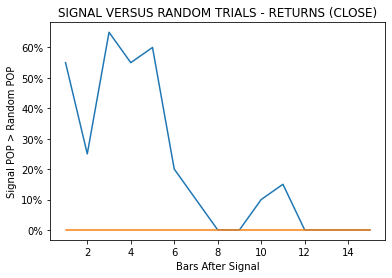

In [5]:
# RANDOM SIGNAL COMPARISON WITH SIGNAL BASED ON CLOSING PRICE
# Calculate POP based on a random signals.  Calculation is repeated 20 times
# and compared to the returns generated by the signal.

# Set the number of trials
cl_trials = 20

# Set up signal versus random performance comparison array
svr_close = [0]*15

print("Frequency of Signal under evaluation (Close):  ", '{:2.2%}'.format(cl_freq))

for i in range(0,cl_trials):
    # Clear the random signal column
    df['CLX'] = 0
    
    # Generate a random number for each line/bar in the file
    for j, row in df.iterrows():
        df.at[j,'cl_x'] = random.random()
        
    # use the frequency of the signal (sigfreq) to generate a random signal
    df.loc[(df['cl_x'] < cl_freq), 'CLX'] = 1
    
    # Clear the support column
    df['RCL_SUPPORT'] = 0
    # Set random support level to the low of the signal bar
    df.loc[(df['CLX'] == 1), 'RCL_SUPPORT'] = df['Low']
    
    # How many random signals were generated?
    signals = df['CLX'].sum()  
   
    # Signal Frequency
    r_freq = 0
    if bars != 0:
        r_freq = signals/bars

    print("Frequency of Random Signal:  ", '{:2.2%}'.format(r_freq))
    
    # Clean support columns
    for j in range(0,15):
        df['RCL' + str(j + 1)] = 0
        
    # Determine the number of times support holds
    for j in range(0,15):
        df.loc[(df['CLX'] == 1) & (df['Close'].shift(-(j+1)) > df['RCL_SUPPORT']), 'RCL' + str(j + 1)] = 1

    random_close = [0]*15
    for j in range(0,15):
        if signals != 0:
            random_close[j] = df['RCL' + str(j + 1)].sum()/signals
    
    # Compare to statistics from the trading signal
    for j in range(0,15):
        if pop_close[j] > random_close[j]:
            svr_close[j] += 1

for i in range(0,15):
    svr_close[i] /= cl_trials
    
plt.title("SIGNAL VERSUS RANDOM TRIALS - RETURNS (CLOSE)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, svr_close)
plt.plot(bar_count, zeros)
plt.xlabel('Bars After Signal')
plt.ylabel('Signal POP > Random POP')
print("")

In [6]:
# BUY STOP SCENARIO - Assume we wait until a buy stop order would have filled.
# Calculate returns on the high price of the signal bar - assuming the next bar takes out the high
# This is a buy stop scenario.

df.loc[(df['SIGNAL'] == 1) & (df['High'].shift(-1) > df['High']), 'BS_fill'] = 1

# How many fills for the buy stop?
bs_fill = df['BS_fill'].sum()

# Signal Frequency
bs_freq = 0
if bars != 0:
    bs_freq = bs_fill/bars

print("There were ", int(bs_fill), " signals")
print("Probablity of Trading Signal:  ", '{:2.2%}'.format(bs_freq))

There were  9  signals
Probablity of Trading Signal:   1.15%


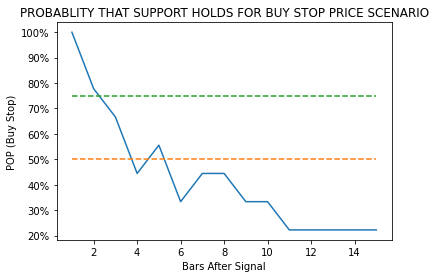

In [7]:
# BUY STOP SUPPORT CALCULATIONS - Calculate the probability of support holding 
# based upon entering with a buy stop.  Assumes you are watching the market and can enter 
# when the high of the signal bar is taken out by the next bar.

# Clear the support column
for i in range(0,15):
    df['SBS' + str(i + 1)] = 0
    
# Test the closing price of each bar after the trading signal
for i in range(0,15):
    df.loc[(df['BS_fill'] == 1) & 
           (df['Close'].shift(-(i+1)) > df['SUPPORT']), 'SBS' + str(i + 1)] = 1

# Find the probablity of support breaking.  These are not cummulative probabilities.
# Note that support could be broken on bar 2 and 7 in which case the violation of support
# would be recorded for both bars 2 and 7.  The assumption is that if you are interested
# in support at bar 7 you won't necessarily care about bar 2 breaking support.
pop_buystop = [0]*15
for i in range(0,15):
    if signals != 0:
        pop_buystop[i] = df['SBS' + str(i + 1)].sum()/bs_fill

# Plot the return results
plt.title("PROBABLITY THAT SUPPORT HOLDS FOR BUY STOP PRICE SCENARIO")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, pop_buystop)
plt.plot(bar_count, fifty, '--')
plt.plot(bar_count, seventy_five, '--')
plt.xlabel('Bars After Signal')
plt.ylabel('POP (Buy Stop)')
print("")

Frequency of Signal under evaluation (Buy Stop):   1.15%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   0.64%
Frequency of Random Signal:   0.38%
Frequency of Random Signal:   0.90%
Frequency of Random Signal:   0.64%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   0.64%
Frequency of Random Signal:   0.77%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   0.38%
Frequency of Random Signal:   0.77%
Frequency of Random Signal:   0.26%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   0.64%
 


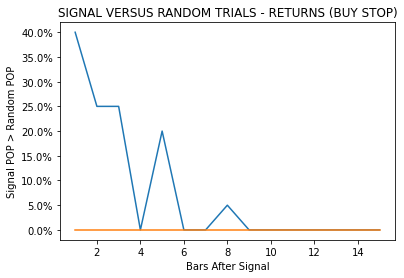

In [8]:
# RANDOM SIGNAL COMPARISON WITH SIGNAL BASED ON BUY STOP
# Calculate POP based on a random signals.  Calculation is repeated 20 times
# and compared to the returns generated by the signal.

# Set the number of trials
bs_trials = 20

# Set up signal versus random performance comparison array
svr_buystop = [0]*15

print("Frequency of Signal under evaluation (Buy Stop):  ", '{:2.2%}'.format(bs_freq))

for i in range(0,bs_trials):
    # Clear the random signal column
    df['BSX'] = 0
    
    # Generate a random number for each line/bar in the file
    for j, row in df.iterrows():
        df.at[j,'bs_x'] = random.random()
        
    # use the frequency of the signal (bsfreq) to generate a random signal
    df.loc[(df['bs_x'] < bs_freq) & (df['High'].shift(-1) > df['High']), 'BSX'] = 1

    # Clear the support column
    df['RBS_SUPPORT'] = 0
    # Set random support level to the low of the signal bar 
    df.loc[(df['BSX'] == 1), 'RBS_SUPPORT'] = df['Low']
    
    # How many random signals were generated?
    signals = df['BSX'].sum()  

    # Signal Frequency
    r_freq = 0
    if bars != 0:
        r_freq = signals/bars

    print("Frequency of Random Signal:  ", '{:2.2%}'.format(r_freq))  
    
    # Clean support columns
    for j in range(0,15):
        df['RBS' + str(j + 1)] = 0
        
    # Determine the number of times support holds with a buy stop order
    for j in range(0,15):
        df.loc[(df['BSX'] == 1) & (df['Close'].shift(-(j+1)) > df['RBS_SUPPORT']), 'RBS' + str(j + 1)] = 1

    random_buystop = [0]*15
    for j in range(0,15):
        if signals != 0:
            random_buystop[j] = df['RBS' + str(j + 1)].sum()/signals
    
    # Compare to statistics from the trading signal
    for j in range(0,15):
        if pop_buystop[j] > random_buystop[j]:
            svr_buystop[j] += 1
    
for i in range(0,15):
    svr_buystop[i] /= bs_trials

plt.title("SIGNAL VERSUS RANDOM TRIALS - RETURNS (BUY STOP)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, svr_buystop)
plt.plot(bar_count, zeros)
plt.xlabel('Bars After Signal')
plt.ylabel('Signal POP > Random POP')
print(" ")